In [2]:
import tushare as ts

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

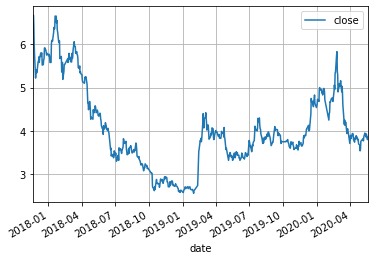

In [6]:
data = ts.get_hist_data('000725')
data = data.reset_index().sort_values('date')
data = data.reset_index()
data['date'] = data['date'].astype('M8[D]')
data.plot(x='date', y='close', grid=True)

In [7]:
# 传入时间,假设为当前日期,根据已知数据,返回策略
def profit(mdate):
    """
    基于均线理论,判断金叉死叉,返回响应结果
    """
    mask = data['date'] <= mdate
    if len(data[mask]) < 2:
        return 0
    today_data = data[mask].iloc[-1]
    yesday_data = data[mask].iloc[-2]
    #  昨天的5日均线与10日均线
    yma5, yma10 = yesday_data['ma5'], yesday_data['ma10']
    #  今天的5日均线与10日均线
    tma5, tma10 = today_data['ma5'], today_data['ma10']

    if (yma10 >= yma5) and (tma10 <= tma5):
        return 1
    elif (yma10 <= yma5) and (tma10 >= tma5):
        return -1
    return 0

In [8]:
profit_vec = np.vectorize(profit)

In [9]:
result = profit_vec(data['date'])
(result == 1).sum()

40

In [10]:
assets = 1000000
stocks = 0
payment_price = 0
status = 0
for index, profit in enumerate(result):
    current_price = data['close'][index]
    # 如果是买入并且赔了的状态，若已经跌出5%，则强制卖出
    if status == 1:
        payment_assets = payment_price * stocks
        current_assets = current_price * stocks
        if (payment_assets > current_assets) and (
            (payment_assets - current_assets) > payment_assets * 0.05):
            payment_price = current_price
            assets = assets + stocks * payment_price
            stocks = 0
            status = -1
            print('止损：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
                  format(data['date'][index], current_price, assets, stocks))
    if (profit == 1) and (status != 1):  # 买入
        payment_price = current_price
        stocks = int(assets / payment_price)
        assets = assets - stocks * payment_price
        status = 1
        print('买入：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
              format(data['date'][index], current_price, assets, stocks))
    if (profit == -1) and (status != -1):  # 卖出
        payment_price = current_price
        assets = assets + stocks * payment_price
        stocks = 0
        status = -1
        print('卖出：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
              format(data['date'][index], current_price, assets, stocks))
    print('持有：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.format(
        data['date'][index], current_price, assets, stocks))

持有：dates:2017-11-20 00:00:00, curr price:6.27, assets:1000000.00, stocks:0
买入：dates:2017-11-21 00:00:00, curr price:6.67, assets:0.25, stocks:149925
持有：dates:2017-11-21 00:00:00, curr price:6.67, assets:0.25, stocks:149925
持有：dates:2017-11-22 00:00:00, curr price:6.48, assets:0.25, stocks:149925
止损：dates:2017-11-23 00:00:00, curr price:6.06, assets:908545.75, stocks:0
买入：dates:2017-11-23 00:00:00, curr price:6.06, assets:0.25, stocks:149925
持有：dates:2017-11-23 00:00:00, curr price:6.06, assets:0.25, stocks:149925
持有：dates:2017-11-24 00:00:00, curr price:5.78, assets:0.25, stocks:149925
止损：dates:2017-11-27 00:00:00, curr price:5.22, assets:782608.75, stocks:0
持有：dates:2017-11-27 00:00:00, curr price:5.22, assets:782608.75, stocks:0
持有：dates:2017-11-28 00:00:00, curr price:5.39, assets:782608.75, stocks:0
持有：dates:2017-11-29 00:00:00, curr price:5.41, assets:782608.75, stocks:0
持有：dates:2017-11-30 00:00:00, curr price:5.34, assets:782608.75, stocks:0
持有：dates:2017-12-01 00:00:00, curr pr